In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [68]:
df = pd.read_csv(r"C:\Users\DELL\Downloads\DOGE-USD.csv")
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-11-09,0.001207,0.001415,0.001181,0.001415,0.001415,6259550
2017-11-10,0.001421,0.001431,0.001125,0.001163,0.001163,4246520
2017-11-11,0.001146,0.001257,0.001141,0.001201,0.001201,2231080
2017-11-12,0.001189,0.001210,0.001002,0.001038,0.001038,3288960
2017-11-13,0.001046,0.001212,0.001019,0.001211,0.001211,2481270
...,...,...,...,...,...,...
2022-07-23,0.067531,0.069332,0.066277,0.068124,0.068124,427922351
2022-07-24,0.068116,0.068854,0.067589,0.067724,0.067724,369141492
2022-07-25,0.067716,0.067880,0.062306,0.062306,0.062306,448572441


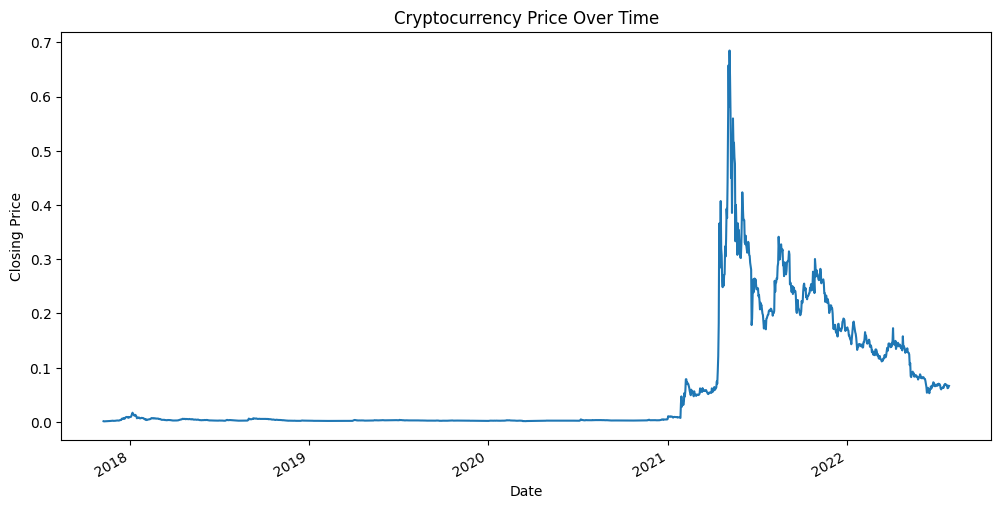

In [69]:
df['Close'].plot(figsize=(12, 6))
plt.title('Cryptocurrency Price Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.show()

In [70]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
df_normalized = scaler.fit_transform(df[['Close']])


In [71]:
# Create sequences for the LSTM model
def create_sequences(data, look_back):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back), 0])
        y.append(data[i + look_back, 0])
    return np.array(X), np.array(y)

look_back = 10
X, y = create_sequences(df_normalized, look_back)


In [72]:
# Split the data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape the input data for LSTM
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [73]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, input_shape=(X_train.shape[1], 1)))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32)


Epoch 1/50
43/43 [==============================] - 2s 3ms/step - loss: 0.0066
Epoch 2/50
43/43 [==============================] - 0s 3ms/step - loss: 0.0013
Epoch 3/50
43/43 [==============================] - 0s 3ms/step - loss: 0.0013
Epoch 4/50
43/43 [==============================] - 0s 3ms/step - loss: 0.0012
Epoch 5/50
43/43 [==============================] - 0s 3ms/step - loss: 0.0012
Epoch 6/50
43/43 [==============================] - 0s 3ms/step - loss: 0.0011
Epoch 7/50
43/43 [==============================] - 0s 4ms/step - loss: 0.0010
Epoch 8/50
43/43 [==============================] - 0s 4ms/step - loss: 9.5819e-04
Epoch 9/50
43/43 [==============================] - 0s 4ms/step - loss: 8.7023e-04
Epoch 10/50
43/43 [==============================] - 0s 4ms/step - loss: 8.2832e-04
Epoch 11/50
43/43 [==============================] - 0s 4ms/step - loss: 7.8409e-04
Epoch 12/50
43/43 [==============================] - 0s 4ms/step - loss: 7.6500e-04
Epoch 13/50
43/43 [==========

In [74]:
# Make predictions on the test set
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)  

# Evaluate the model
mse = mean_squared_error(df['Close'].iloc[train_size + look_back:], predictions)
print(f'Mean Squared Error: {mse}')

11/11 [==============================] - 0s 2ms/step
Mean Squared Error: 0.0001601997801211116


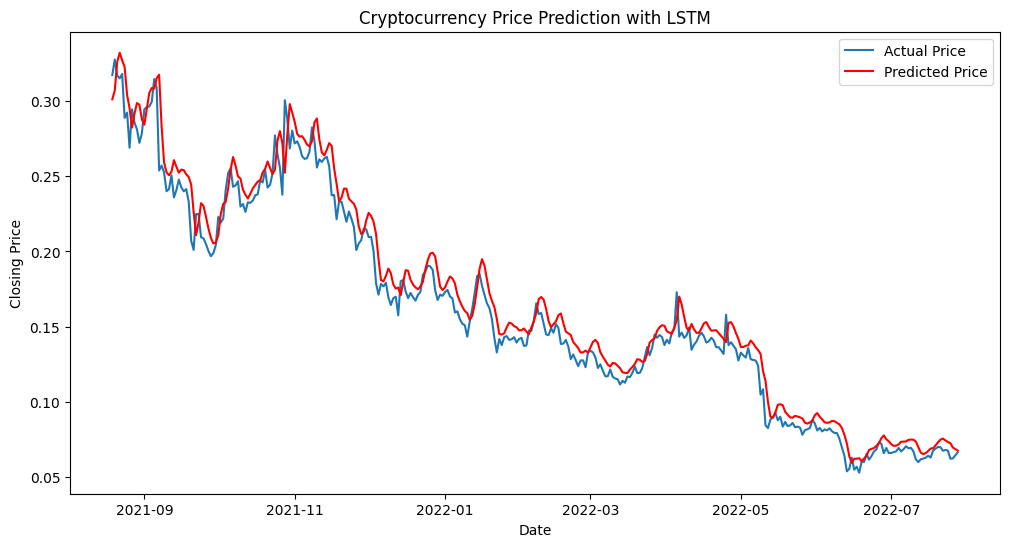

In [75]:
# Visualize the predictions
plt.figure(figsize=(12, 6))
plt.plot(df.index[train_size + look_back:], df['Close'].iloc[train_size + look_back:], label='Actual Price')
plt.plot(df.index[train_size + look_back:], predictions, label='Predicted Price', color='red')
plt.title('Cryptocurrency Price Prediction with LSTM')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

In [76]:
# Make predictions into the future
future_steps = 30  # Number of steps into the future to predict
future_predictions = []

# Use the last 'look_back' values from the training set as the initial input for prediction
current_sequence = X_test[-1].flatten()

for _ in range(future_steps):
    # Reshape the current sequence for prediction
    current_sequence = current_sequence.reshape((1, look_back, 1))
    
    # Predict the next data point
    next_prediction = model.predict(current_sequence)
    
    # Append the prediction to the list
    future_predictions.append(next_prediction[0, 0])
    
    # Update the current sequence by removing the first element and adding the prediction
    current_sequence = np.append(current_sequence[:, 1:, :], [[next_prediction[0, 0]]], axis=1)

# Inverse transform to get original scale
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Visualize the predictions into the future
dates_future = pd.date_range(start=df.index[-1], periods=future_steps + 1, freq='D')[1:]
plt.figure(figsize=(12, 6))
plt.plot(df.index[-100:], df['Close'].tail(100), label='Historical Price')
plt.plot(dates_future, future_predictions, label='Predicted Price (Future)', color='red', linestyle='--')
plt.title('Cryptocurrency Price Prediction with LSTM (Future)')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

1/1 [==============================] - 0s 18ms/step


ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 3 dimension(s) and the array at index 1 has 2 dimension(s)